In [ ]:
import pandas as pd

# Load the uploaded CSV file
file_path = './diabetic-retinopathy-detection/trainLabels.csv'
data = pd.read_csv(file_path)

# Analyze the count of each DR grade
dr_grade_counts = data['level'].value_counts()

# Display the counts
dr_grade_counts

In [8]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Reshape, multiply
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


# 路径设置
images_dir = 'autodl-fs/Balanced_images4'
labels_file_path = 'balanced_labels_with_borderline_smote4.csv'
# 加载标签数据
labels = pd.read_csv(labels_file_path)
# 划分训练集和验证集
train_df, val_df = train_test_split(labels, test_size=0.2, stratify=labels['level'], random_state=30)

# 确保标签列是字符串类型
train_df['level'] = train_df['level'].astype(str)
val_df['level'] = val_df['level'].astype(str)

# 图像生成器
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=images_dir,
    x_col='image',
    y_col='level',
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

val_gen = validation_datagen.flow_from_dataframe(
    val_df,
    directory=images_dir,
    x_col='image',
    y_col='level',
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



# 加载预训练的VGG16模型
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# # 冻结前四个卷积块
# for layer in base_model.layers[:7]:  # 冻结至Block4的所有层
#     layer.trainable = False   
# 确保所有层都是可训练的
for layer in base_model.layers:
    layer.trainable = True
# for layer in base_model.layers[:15]:  # 冻结 VGG16 前15层
#     layer.trainable = False

# 替换分类层
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 全局平均池化
x = Dense(1000, activation='relu')(x)  # 第一层全连接层，1000个神经元
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)  # Dropout层，防止过拟合
x = Dense(100, activation='relu')(x)  # 第二层全连接层，100个神经元
x = BatchNormalization()(x)
x = Dense(5, activation='softmax')(x)  # 输出层，5个类别（No DR, Mild DR, Moderate DR, Severe DR, Proliferative DR）



# 构建模型
model = Model(inputs=base_model.input, outputs=x)

optimizer = SGD(learning_rate=1e-4, momentum=0.9)
# 编译模型
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 设置回调
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# 训练模型时添加回调
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Found 14000 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.
Epoch 1/80
438/438 [==============================] - 1486s 3s/step - loss: 1.2732 - accuracy: 0.4699 - val_loss: 1.2733 - val_accuracy: 0.4397 - lr: 1.0000e-04
Epoch 2/80
438/438 [==============================] - 1067s 2s/step - loss: 1.0315 - accuracy: 0.5806 - val_loss: 1.0345 - val_accuracy: 0.5937 - lr: 1.0000e-04
Epoch 3/80
438/438 [==============================] - 1028s 2s/step - loss: 0.9573 - accuracy: 0.6131 - val_loss: 1.5029 - val_accuracy: 0.4520 - lr: 1.0000e-04
Epoch 4/80
438/438 [==============================] - 941s 2s/step - loss: 0.9090 - accuracy: 0.6351 - val_loss: 2.8914 - val_accuracy: 0.3954 - lr: 1.0000e-04
Epoch 5/80
438/438 [==============================] - 930s 2s/step - loss: 0.8786 - accuracy: 0.6489 - val_loss: 1.5344 - val_accuracy: 0.5117 - lr: 1.0000e-04
Epoch 6/80
438/438 [==============================] - 958s 2s/step - loss:

In [9]:
# 在验证集上评估模型
val_gen.reset()
loss, accuracy = model.evaluate(val_gen)
print(f"验证集准确率: {accuracy:.2f}")

110/110 [==============================] - 43s 389ms/step - loss: 0.4213 - accuracy: 0.8426
验证集准确率: 0.84


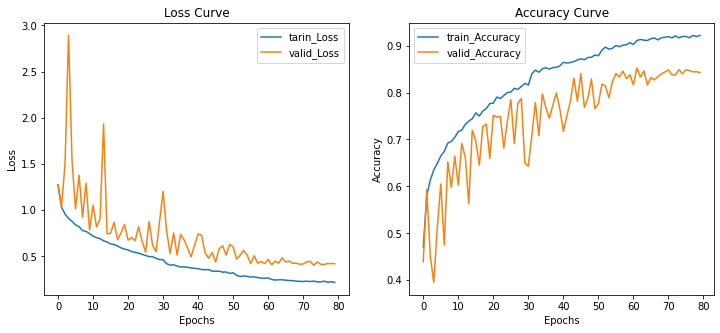

In [10]:
# 可视化训练过程
plt.figure(figsize=(12, 5))

# Loss曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='tarin_Loss')
plt.plot(history.history['val_loss'], label='valid_Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_Accuracy')
plt.plot(history.history['val_accuracy'], label='valid_Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

110/110 [==============================] - 49s 438ms/step


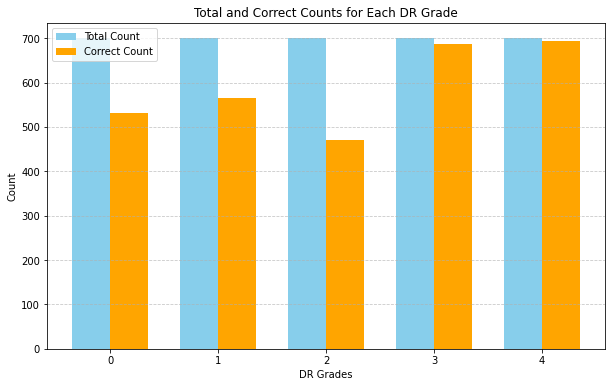

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 获取预测结果和实际标签
predictions = model.predict(val_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_gen.classes

# 获取分类标签
class_labels = list(val_gen.class_indices.keys())

# 统计每个类别的总数量
true_counts = Counter(true_classes)

# 统计每个类别的预测正确的数量
correct_counts = Counter()
for true, pred in zip(true_classes, predicted_classes):
    if true == pred:  # 如果预测正确，计数增加
        correct_counts[true] += 1

# 确保每个类别都在结果中，即使没有正确预测的类别
total_counts = [true_counts[i] for i in range(len(class_labels))]
correct_counts = [correct_counts.get(i, 0) for i in range(len(class_labels))]

# 可视化每类的总数量和正确数量
x = np.arange(len(class_labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, total_counts, width, label='Total Count', color='skyblue')
plt.bar(x + width/2, correct_counts, width, label='Correct Count', color='orange')

plt.xticks(x, class_labels)
plt.xlabel('DR Grades')
plt.ylabel('Count')
plt.title('Total and Correct Counts for Each DR Grade')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# 计算每个类别的准确率
class_accuracies = []
for i in range(len(class_labels)):
    if total_counts[i] > 0:
        accuracy = correct_counts[i] / total_counts[i]
    else:
        accuracy = 0
    class_accuracies.append(accuracy)

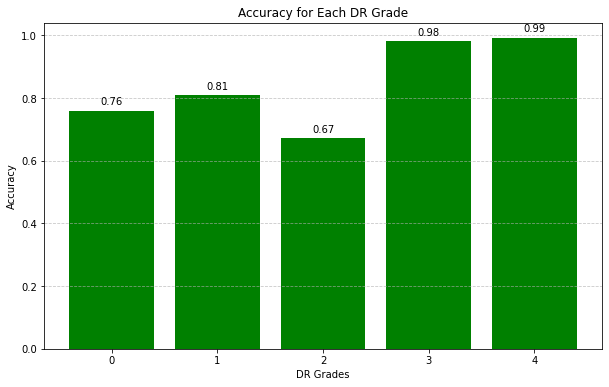

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(x, class_accuracies, color='green')
plt.xticks(x, class_labels)
plt.xlabel('DR Grades')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each DR Grade')
for i, val in enumerate(class_accuracies):
    plt.text(i, val + 0.02, f"{val:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

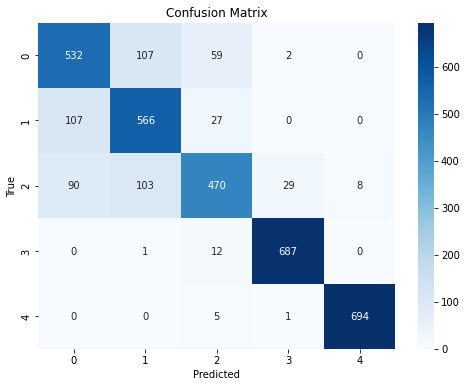

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import precision_recall_fscore_support

# 假设您已经有 true_classes 和 predicted_classes
# class_labels = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5']

# 计算 Precision, Recall 和 F1-score
precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes, labels=range(len(class_labels)))

# 打印每个类别的结果
print("Class-wise Metrics:")
for i, label in enumerate(class_labels):
    print(f"Class: {label}")
    print(f" Precision: {precision[i]:.2f}")
    print(f" Recall: {recall[i]:.2f}")
    print(f" F1-score: {f1[i]:.2f}")
    print(f" Support: {support[i]}\n")

# 可选：汇总为 DataFrame 格式（便于导出或展示）
import pandas as pd
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
})
print(metrics_df)

Class-wise Metrics:
Class: 0
 Precision: 0.73
 Recall: 0.76
 F1-score: 0.74
 Support: 700

Class: 1
 Precision: 0.73
 Recall: 0.81
 F1-score: 0.77
 Support: 700

Class: 2
 Precision: 0.82
 Recall: 0.67
 F1-score: 0.74
 Support: 700

Class: 3
 Precision: 0.96
 Recall: 0.98
 F1-score: 0.97
 Support: 700

Class: 4
 Precision: 0.99
 Recall: 0.99
 F1-score: 0.99
 Support: 700

  Class  Precision    Recall  F1-score  Support
0     0   0.729767  0.760000  0.744577      700
1     1   0.728443  0.808571  0.766418      700
2     2   0.820244  0.671429  0.738413      700
3     3   0.955494  0.981429  0.968288      700
4     4   0.988604  0.991429  0.990014      700


In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Reshape, multiply
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
# 加载预训练的VGG16模型
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 24, 3))

# # 冻结前四个卷积块
# for layer in base_model.layers[:7]:  # 冻结至Block4的所有层
#     layer.trainable = False   
# 确保所有层都是可训练的
for layer in base_model.layers:
    layer.trainable = True
# for layer in base_model.layers[:15]:  # 冻结 VGG16 前15层
#     layer.trainable = False

# 替换分类层
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 全局平均池化
x = Dense(1000, activation='relu')(x)  # 第一层全连接层，1000个神经元
x = BatchNormalization()(x)
# x = Dropout(0.2)(x)  # Dropout层，防止过拟合
x = Dense(100, activation='relu')(x)  # 第二层全连接层，100个神经元
x = BatchNormalization()(x)
x = Dense(5, activation='softmax')(x)  # 输出层，5个类别（No DR, Mild DR, Moderate DR, Severe DR, Proliferative DR）



# 构建模型
model = Model(inputs=base_model.input, outputs=x)

In [12]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0   

In [ ]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'balanced_labels_with_sbs_smote.csv'
data = pd.read_csv(file_path)

# Analyze the count of each DR grade
dr_grade_counts = data['level'].value_counts()

# Display the counts
dr_grade_counts